In [1]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt


import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import os
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')

In [2]:
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
dc_products[dc_products['name'].str.contains("pq_albers")][display_columns].set_index('name')

,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
ls5_pq_albers,"Landsat 5 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"
ls7_pq_albers,"Landsat 7 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"
ls8_pq_albers,"Landsat 8 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"


In [3]:
lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
#time_range = ('2016-01-01', '2016-12-31')
time_range = ('2017-04-01', '2017-11-30')
resolution = (-25, 25)
landsat_goodquality_prop = 0.3

ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15

In [4]:
x, y = geometry.point(lon1, lat1, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m1, x + buffer_m1),
         'y': (y - buffer_m1, y + buffer_m1),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

In [5]:
# Load data
landsat_ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query1)

# Set all nodata pixels to `NaN`:
landsat_ds = masking.mask_invalid_data(landsat_ds)
landsat_ds

<xarray.Dataset>
Dimensions:          (time: 31, x: 641, y: 641)
Coordinates:
  * time             (time) datetime64[ns] 2017-04-04T23:56:25 ... 2017-11-30T23:57:01
  * y                (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x                (x) float64 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 123.0 129.0 ... 6.275e+03 6.213e+03
    blue             (time, y, x) float64 76.0 68.0 ... 5.983e+03 5.891e+03
    green            (time, y, x) float64 185.0 168.0 ... 5.978e+03 5.906e+03
    red              (time, y, x) float64 135.0 130.0 ... 6.019e+03 5.945e+03
    nir              (time, y, x) float64 1.587e+03 1.474e+03 ... 6.597e+03
    swir1            (time, y, x) float64 618.0 528.0 ... 3.432e+03 3.404e+03
    swir2            (time, y, x) float64 238.0 218.0 ... 3.05e+03 3.027e+03
Attributes:
    crs:      EPSG:3577

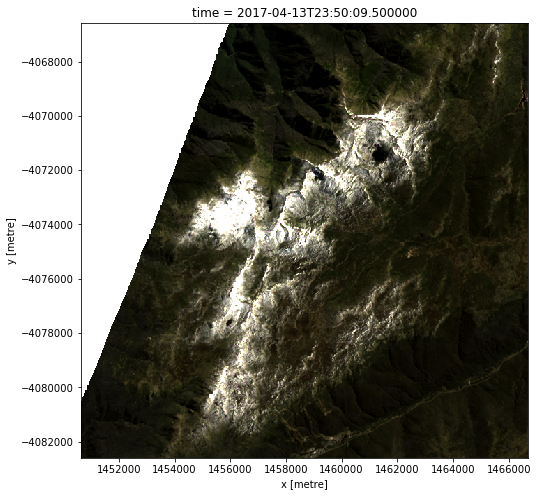

In [6]:
landsat_ds[['red', 'green', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(8, 8))

In [7]:
valid_ds = np.isfinite(landsat_ds.swir1)

In [8]:
ndsi_ds = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)
ndvi_ds = (landsat_ds.nir - landsat_ds.red) / (landsat_ds.nir + landsat_ds.red)
ndwi_ds = (landsat_ds.green - landsat_ds.nir)/(landsat_ds.green + landsat_ds.nir)

In [9]:
snow_ds = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
nowater_ds = ndwi_ds < ndwi_threshold
snow_ds = noveg_ds & snow_ds &nowater_ds

In [10]:
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query1)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 31, x: 641, y: 641)
Coordinates:
  * time          (time) datetime64[ns] 2017-04-04T23:56:25 ... 2017-11-30T23:57:01
  * y             (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x             (x) float64 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 13311 13311 13311
Attributes:
    crs:      EPSG:3577

In [57]:
#sensor_pq.pixelquality.values

In [11]:
dvf = masking.describe_variable_flags(sensor_pq)
dvf

,bits,values,description
land_sea,9,"{'0': 'sea', '1': 'land'}",Land or Sea
cloud_acca,10,"{'0': 'cloud', '1': 'no_cloud'}",Cloud (ACCA)
contiguous,8,"{'0': False, '1': True}",All bands for this pixel contain non-null values
cloud_fmask,11,"{'0': 'cloud', '1': 'no_cloud'}",Cloud (Fmask)
ga_good_pixel,"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",{'16383': True},Best Quality Pixel
nir_saturated,3,"{'0': True, '1': False}",NIR band is saturated
red_saturated,2,"{'0': True, '1': False}",Red band is saturated
blue_saturated,0,"{'0': True, '1': False}",Blue band is saturated
tir1_saturated,5,"{'0': True, '1': False}",Thermal Infrared 1 band is saturated
tir2_saturated,6,"{'0': True, '1': False}",Thermal Infrared 2 band is saturated


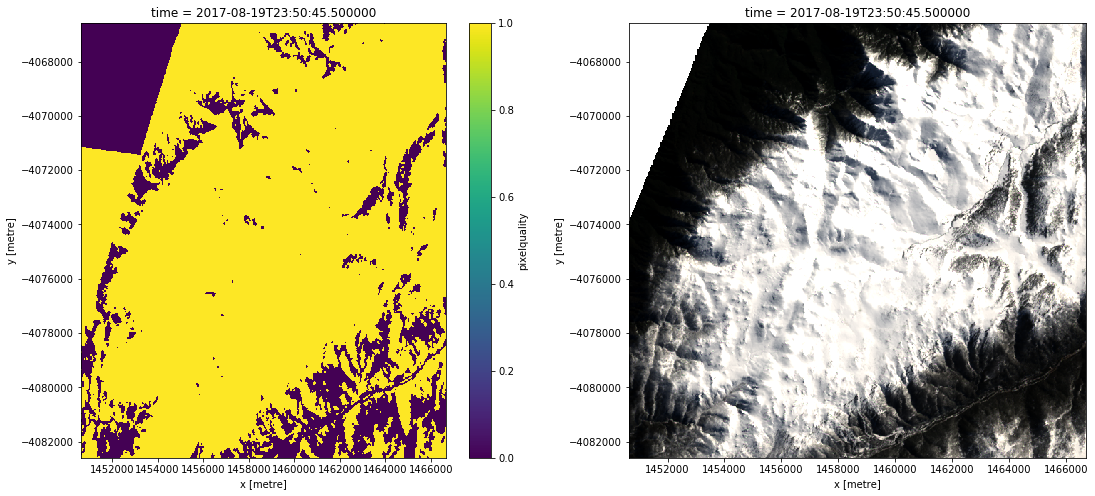

In [12]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 #cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 #contiguous=True
                                )
# good_quality.isel(time=1).plot(figsize=(8,8))

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 8)
                        )
i=17
good_quality.isel(time=i).plot(ax=axes[0])
landsat_ds[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[1])

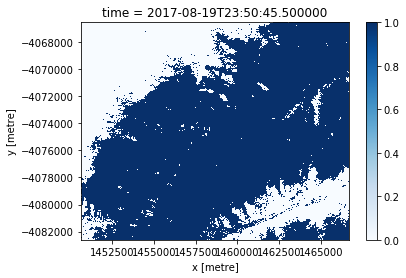

In [13]:
snow_ds.isel(time=i).plot(cmap='Blues')

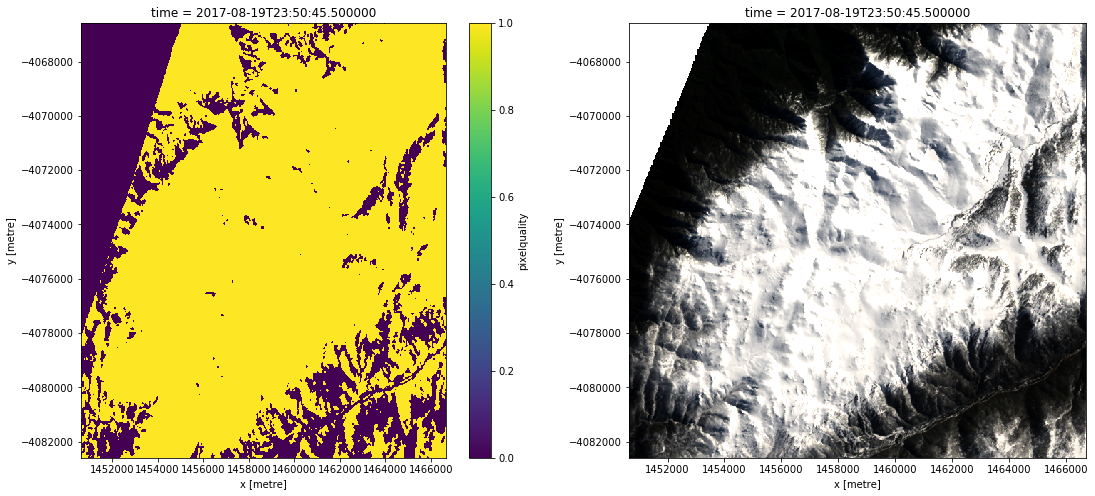

In [27]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True
                                )
# good_quality.isel(time=1).plot(figsize=(8,8))



import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 8)
                        )
i=17
good_quality.isel(time=i).plot(ax=axes[0])
landsat_ds[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[1])





In [19]:
snow_mask = dict(cloud_acca='no_cloud',
                 cloud_fmask='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True)
landsat_ds1 = DEADataHandling.load_clearlandsat(dc=dc,
                                               product = 'nbar',
                                               query=query1,
                                               mask_dict=snow_mask,
                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 5 filtered ls7 timesteps
Loading ls8
    Loading 15 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [23]:
valid_ds1 = np.isfinite(landsat_ds1.swir1)

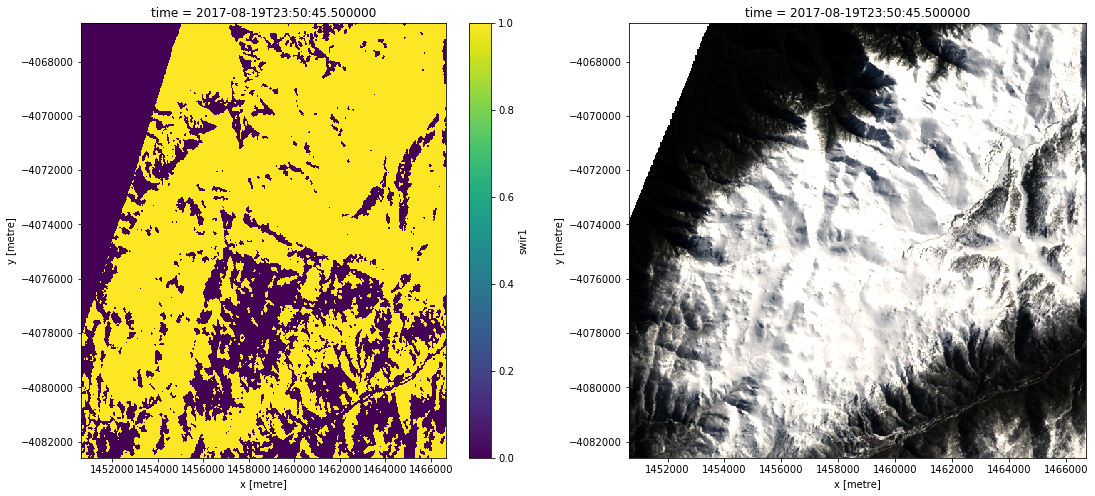

In [26]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 8)
                        )
i=17
valid_ds1.isel(time=11).plot(ax=axes[0])
landsat_ds[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[1])

In [45]:
ds_masked = landsat_ds.where(good_quality)
ds_masked

<xarray.Dataset>
Dimensions:          (time: 31, x: 641, y: 641)
Coordinates:
  * time             (time) datetime64[ns] 2017-04-04T23:56:25 ... 2017-11-30T23:57:01
  * y                (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x                (x) float64 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 123.0 129.0 131.0 ... nan nan nan
    blue             (time, y, x) float64 76.0 68.0 111.0 131.0 ... nan nan nan
    green            (time, y, x) float64 185.0 168.0 256.0 ... nan nan nan
    red              (time, y, x) float64 135.0 130.0 219.0 ... nan nan nan
    nir              (time, y, x) float64 1.587e+03 1.474e+03 ... nan nan
    swir1            (time, y, x) float64 618.0 528.0 811.0 ... nan nan nan
    swir2            (time, y, x) float64 238.0 218.0 359.0 ... nan nan nan
Attributes:
    crs:      EPSG:3577

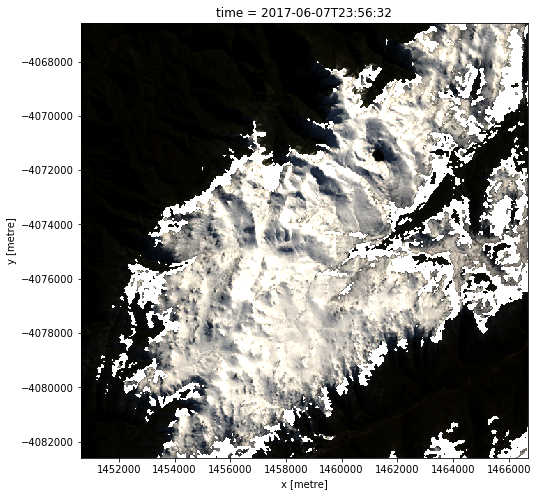

In [46]:
ds_masked[['red', 'green', 'blue']].isel(time=8).to_array().plot.imshow(robust=True, figsize=(8, 8))